In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

# Cargar datos
df = pd.read_csv('Datos/heart.csv')

# Revisar las primeras filas
df.head()

# Verificar el tamaño del dataframe y buscar NAs
print(df.shape)
print(df.isna().sum())

# Definir un subconjunto de variables categóricas y numéricas
cat_int_feats = ['sex', 'cp', 'restecg', 'exang']
num_feats = ['age', 'trestbps', 'chol', 'thalach']

# Seleccionar el subconjunto de variables junto con la columna objetivo
feats_ordered = cat_int_feats + num_feats
df = df[feats_ordered + ['target']]

# Verificar el dataframe ajustado
df.head()


(303, 14)
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


,sex,cp,restecg,exang,age,trestbps,chol,thalach,target
0,1,1,2,0,63,145,233,150,0
1,1,4,2,1,67,160,286,108,1
2,1,4,2,1,67,120,229,129,0
3,1,3,0,0,37,130,250,187,0
4,0,2,2,0,41,130,204,172,0


In [2]:
# Separar en entrenamiento, validación y prueba
train = df.sample(frac=0.8, random_state=100)
test = df.drop(train.index)
val = train.sample(frac=0.2, random_state=100)
train = train.drop(val.index)

# Verificar los tamaños de cada conjunto
print(train.shape, val.shape, test.shape)


(194, 9) (48, 9) (61, 9)


In [3]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("target")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

train_ds = dataframe_to_dataset(train)
val_ds = dataframe_to_dataset(val)
test_ds = dataframe_to_dataset(test)


In [4]:
batch_size = 32
train_ds = train_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [5]:
def encode_numerical_feature(feature, name, dataset):
    normalizer = keras.layers.Normalization()
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))
    normalizer.adapt(feature_ds)
    return normalizer(feature)

def encode_categorical_feature(feature, name, dataset):
    lookup = keras.layers.IntegerLookup(output_mode="binary")
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))
    lookup.adapt(feature_ds)
    return lookup(feature)


In [11]:
inputs = []
feats_encoded = []

# Agregar las entradas para las variables categóricas y numéricas
for feat in cat_int_feats:
    input_feature = keras.Input(shape=(1,), name=feat, dtype="int64")
    encoded_feature = encode_categorical_feature(input_feature, feat, train_ds)
    inputs.append(input_feature)
    feats_encoded.append(encoded_feature)

for feat in num_feats:
    input_feature = keras.Input(shape=(1,), name=feat)
    encoded_feature = encode_numerical_feature(input_feature, feat, train_ds)
    inputs.append(input_feature)
    feats_encoded.append(encoded_feature)

# Concatenar todas las variables codificadas
all_feats = keras.layers.concatenate(feats_encoded)

# Agregar capas de la red neuronal
x = keras.layers.Dense(32, activation='relu')(all_feats)
output = keras.layers.Dense(1, activation='sigmoid')(x)

# Crear el modelo
model = keras.Model(inputs=inputs, outputs=output)

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [12]:
# Entrenar el modelo
history = model.fit(train_ds, validation_data=val_ds, epochs=50)


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.3344 - loss: 0.7917 - val_accuracy: 0.3542 - val_loss: 0.7893
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4828 - loss: 0.7372 - val_accuracy: 0.4167 - val_loss: 0.7486
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5180 - loss: 0.7093 - val_accuracy: 0.6042 - val_loss: 0.7150
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6563 - loss: 0.6687 - val_accuracy: 0.6458 - val_loss: 0.6849
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7162 - loss: 0.6305 - val_accuracy: 0.7292 - val_loss: 0.6589
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7574 - loss: 0.6000 - val_accuracy: 0.7500 - val_loss: 0.6414
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7698 - loss: 0.5835 - val_accuracy: 0.7500 - val_loss: 0.6273
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7037 - loss: 0.6068 - val_accuracy: 0.7500 - val_loss: 0.6151
Epoch 9

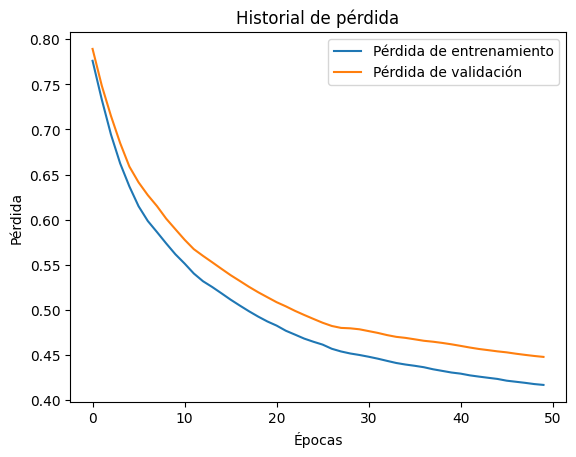

In [13]:
import matplotlib.pyplot as plt

# Graficar la pérdida
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Historial de pérdida')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


In [9]:
from sklearn.metrics import classification_report, confusion_matrix

# Obtener predicciones
y_true = test['target'].values
y_pred_probs = model.predict(test_ds)
y_pred = (y_pred_probs > 0.5).astype(int)

# Calcular métricas
print(classification_report(y_true, y_pred, target_names=['No enfermedad', 'Enfermedad']))
print("Matriz de confusión:\n", confusion_matrix(y_true, y_pred))



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
               precision    recall  f1-score   support

No enfermedad       0.66      1.00      0.79        40
   Enfermedad       0.00      0.00      0.00        21

     accuracy                           0.66        61
    macro avg       0.33      0.50      0.40        61
 weighted avg       0.43      0.66      0.52        61

Matriz de confusión:
 [[40  0]
 [21  0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.6096 - loss: 0.6579 - val_accuracy: 0.7292 - val_loss: 0.6255
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7435 - loss: 0.6094 - val_accuracy: 0.7500 - val_loss: 0.6100
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7323 - loss: 0.6110 - val_accuracy: 0.6042 - val_loss: 0.6826
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6682 - loss: 0.6352 - val_accuracy: 0.7500 - val_loss: 0.6130
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7671 - loss: 0.5919 - val_accuracy: 0.7500 - val_loss: 0.6022
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7434 - loss: 0.5919 - val_accuracy: 0.7500 - val_loss: 0.5798
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7164 - loss: 0.6178 - val_accuracy: 0.7500 - val_loss: 0.5771
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7561 - loss: 0.5712 - val_accuracy: 0.7500 - val_loss: 0.5698
Epoch 9

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
               precision    recall  f1-score   support

No enfermedad       0.65      0.88      0.74        40
   Enfermedad       0.29      0.10      0.14        21

     accuracy                           0.61        61
    macro avg       0.47      0.49      0.44        61
 weighted avg       0.52      0.61      0.54        61

Matriz de confusión:
 [[35  5]
 [19  2]]


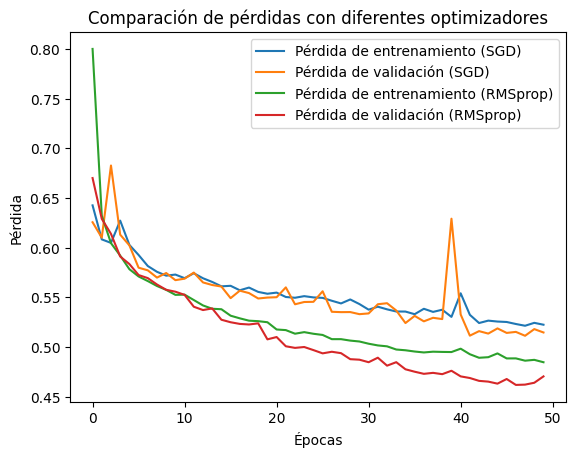

In [10]:
# Crear el modelo base con Adam para referencia
import matplotlib.pyplot as plt
def crear_modelo(optimizer):
    inputs = []
    feats_encoded = []

    for feat in cat_int_feats:
        input_feature = keras.Input(shape=(1,), name=feat, dtype="int64")
        encoded_feature = encode_categorical_feature(input_feature, feat, train_ds)
        inputs.append(input_feature)
        feats_encoded.append(encoded_feature)

    for feat in num_feats:
        input_feature = keras.Input(shape=(1,), name=feat)
        encoded_feature = encode_numerical_feature(input_feature, feat, train_ds)
        inputs.append(input_feature)
        feats_encoded.append(encoded_feature)

    all_feats = keras.layers.concatenate(feats_encoded)
    x = keras.layers.Dense(32, activation='relu')(all_feats)
    output = keras.layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs=inputs, outputs=output)

    # Compilar el modelo con el optimizador que se pase como parámetro
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Crear el modelo con optimizador SGD
sgd_model = crear_modelo(optimizer='sgd')

# Entrenar el modelo
sgd_history = sgd_model.fit(train_ds, validation_data=val_ds, epochs=50)

# Crear el modelo con optimizador RMSprop
rmsprop_model = crear_modelo(optimizer='rmsprop')

# Entrenar el modelo
rmsprop_history = rmsprop_model.fit(train_ds, validation_data=val_ds, epochs=50)

# Evaluar el modelo base, SGD y RMSprop en el conjunto de prueba
def evaluar_modelo(model, test_ds, y_true):
    y_pred_probs = model.predict(test_ds)
    y_pred = (y_pred_probs > 0.5).astype(int)

    print(classification_report(y_true, y_pred, target_names=['No enfermedad', 'Enfermedad']))
    print("Matriz de confusión:\n", confusion_matrix(y_true, y_pred))

# Evaluar modelo con SGD
print("Resultados con optimizador SGD:")
evaluar_modelo(sgd_model, test_ds, y_true)

# Evaluar modelo con RMSprop
print("Resultados con optimizador RMSprop:")
evaluar_modelo(rmsprop_model, test_ds, y_true)

# Graficar las pérdidas de entrenamiento y validación para comparar
plt.plot(sgd_history.history['loss'], label='Pérdida de entrenamiento (SGD)')
plt.plot(sgd_history.history['val_loss'], label='Pérdida de validación (SGD)')
plt.plot(rmsprop_history.history['loss'], label='Pérdida de entrenamiento (RMSprop)')
plt.plot(rmsprop_history.history['val_loss'], label='Pérdida de validación (RMSprop)')
plt.title('Comparación de pérdidas con diferentes optimizadores')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.6196 - loss: 1.1965 - val_accuracy: 0.7500 - val_loss: 0.5944
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7568 - loss: 0.5360 - val_accuracy: 0.6458 - val_loss: 0.6855
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7190 - loss: 0.6773 - val_accuracy: 0.7500 - val_loss: 0.6267
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7537 - loss: 0.6124 - val_accuracy: 0.7500 - val_loss: 0.5750
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7407 - loss: 0.5772 - val_accuracy: 0.7500 - val_loss: 0.5593
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7327 - loss: 0.5745 - val_accuracy: 0.7500 - val_loss: 0.5505
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7289 - loss: 0.5684 - val_accuracy: 0.7500 - val_loss: 0.5202
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7413 - loss: 0.5374 - val_accuracy: 0.7500 - val_loss: 0.4996
Epoch 9

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 446ms/step
               precision    recall  f1-score   support

No enfermedad       0.66      1.00      0.79        40
   Enfermedad       0.00      0.00      0.00        21

     accuracy                           0.66        61
    macro avg       0.33      0.50      0.40        61
 weighted avg       0.43      0.66      0.52        61

Matriz de confusión:
 [[40  0]
 [21  0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


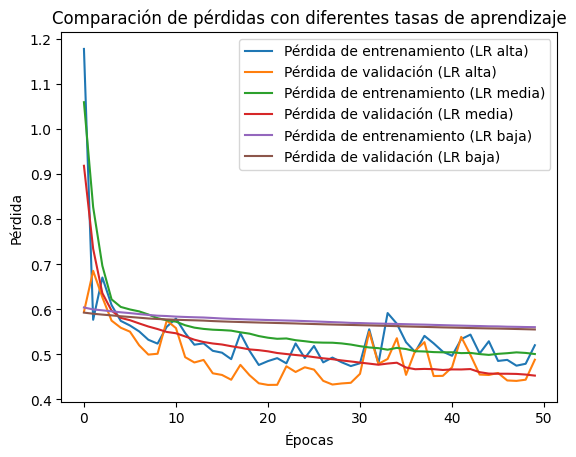

In [11]:
# Crear el modelo base pero con opción de modificar la tasa de aprendizaje
def crear_modelo_lr(learning_rate):
    inputs = []
    feats_encoded = []

    for feat in cat_int_feats:
        input_feature = keras.Input(shape=(1,), name=feat, dtype="int64")
        encoded_feature = encode_categorical_feature(input_feature, feat, train_ds)
        inputs.append(input_feature)
        feats_encoded.append(encoded_feature)

    for feat in num_feats:
        input_feature = keras.Input(shape=(1,), name=feat)
        encoded_feature = encode_numerical_feature(input_feature, feat, train_ds)
        inputs.append(input_feature)
        feats_encoded.append(encoded_feature)

    all_feats = keras.layers.concatenate(feats_encoded)
    x = keras.layers.Dense(32, activation='relu')(all_feats)
    output = keras.layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs=inputs, outputs=output)

    # Usar Adam pero con una tasa de aprendizaje modificada
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Tasa de aprendizaje alta
lr_alta = 0.1
model_lr_alta = crear_modelo_lr(learning_rate=lr_alta)
history_lr_alta = model_lr_alta.fit(train_ds, validation_data=val_ds, epochs=50)

# Tasa de aprendizaje media (base)
lr_media = 0.001
model_lr_media = crear_modelo_lr(learning_rate=lr_media)
history_lr_media = model_lr_media.fit(train_ds, validation_data=val_ds, epochs=50)

# Tasa de aprendizaje baja
lr_baja = 0.0001
model_lr_baja = crear_modelo_lr(learning_rate=lr_baja)
history_lr_baja = model_lr_baja.fit(train_ds, validation_data=val_ds, epochs=50)

# Evaluar los modelos en el conjunto de prueba
def evaluar_modelo(model, test_ds, y_true):
    y_pred_probs = model.predict(test_ds)
    y_pred = (y_pred_probs > 0.5).astype(int)

    print(classification_report(y_true, y_pred, target_names=['No enfermedad', 'Enfermedad']))
    print("Matriz de confusión:\n", confusion_matrix(y_true, y_pred))

# Evaluar modelo con tasa alta
print("Resultados con tasa de aprendizaje alta (0.1):")
evaluar_modelo(model_lr_alta, test_ds, y_true)

# Evaluar modelo con tasa media
print("Resultados con tasa de aprendizaje media (0.001):")
evaluar_modelo(model_lr_media, test_ds, y_true)

# Evaluar modelo con tasa baja
print("Resultados con tasa de aprendizaje baja (0.0001):")
evaluar_modelo(model_lr_baja, test_ds, y_true)

# Graficar las pérdidas de entrenamiento y validación para comparar
plt.plot(history_lr_alta.history['loss'], label='Pérdida de entrenamiento (LR alta)')
plt.plot(history_lr_alta.history['val_loss'], label='Pérdida de validación (LR alta)')
plt.plot(history_lr_media.history['loss'], label='Pérdida de entrenamiento (LR media)')
plt.plot(history_lr_media.history['val_loss'], label='Pérdida de validación (LR media)')
plt.plot(history_lr_baja.history['loss'], label='Pérdida de entrenamiento (LR baja)')
plt.plot(history_lr_baja.history['val_loss'], label='Pérdida de validación (LR baja)')
plt.title('Comparación de pérdidas con diferentes tasas de aprendizaje')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


Resultados con 16 neuronas:
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
               precision    recall  f1-score   support

No enfermedad       0.66      1.00      0.79        40
   Enfermedad       0.00      0.00      0.00        21

     accuracy                           0.66        61
    macro avg       0.33      0.50      0.40        61
 weighted avg       0.43      0.66      0.52        61

Matriz de confusión:
 [[40  0]
 [21  0]]
Resultados con 32 neuronas (modelo base):
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
               precision    recall  f1-score   support

No enfermedad       0.65      0.97      0.78        40
   Enfermedad       0.00      0.00      0.00        21

     accuracy                           0.64        61
    macro avg       0.33      0.49      0.39        61
 weighted avg       0.43      0.64      0.51        61

Matriz de confusión:
 [[39  1]
 [21  0]]
Resultados con 64 neuronas:
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step
               precision    recall  f1-score   support

No enfermedad       0.67      1.00      0.80        40
   Enfermedad       1.00      0.05      0.09        21

     accuracy                           0.67        61
    macro avg       0.83      0.52      0.45        61
 weighted avg       0.78      0.67      0.56        61

Matriz de confusión:
 [[40  0]
 [20  1]]


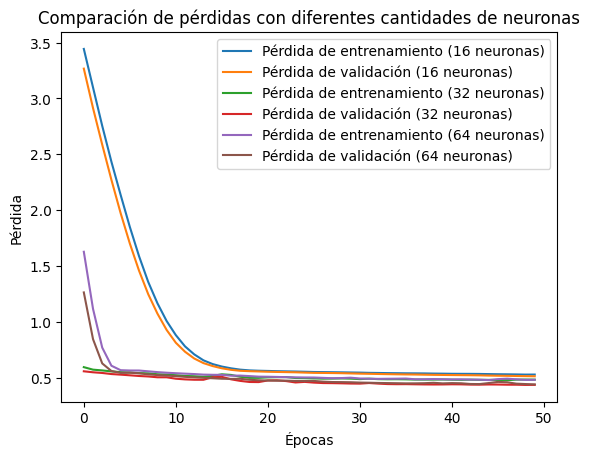

In [12]:
def crear_modelo_neuronas(num_neuronas):
    inputs = []
    feats_encoded = []

    for feat in cat_int_feats:
        input_feature = keras.Input(shape=(1,), name=feat, dtype="int64")
        encoded_feature = encode_categorical_feature(input_feature, feat, train_ds)
        inputs.append(input_feature)
        feats_encoded.append(encoded_feature)

    for feat in num_feats:
        input_feature = keras.Input(shape=(1,), name=feat)
        encoded_feature = encode_numerical_feature(input_feature, feat, train_ds)
        inputs.append(input_feature)
        feats_encoded.append(encoded_feature)

    all_feats = keras.layers.concatenate(feats_encoded)

    # Modificar el número de neuronas aquí
    x = keras.layers.Dense(num_neuronas, activation='relu')(all_feats)
    output = keras.layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs=inputs, outputs=output)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Crear y entrenar modelos con diferentes números de neuronas
# Caso 1: Menos neuronas (16 neuronas)
model_16_neuronas = crear_modelo_neuronas(16)
history_16_neuronas = model_16_neuronas.fit(train_ds, validation_data=val_ds, epochs=50, verbose=0)

# Caso 2: Neuronas base (32 neuronas)
model_32_neuronas = crear_modelo_neuronas(32)
history_32_neuronas = model_32_neuronas.fit(train_ds, validation_data=val_ds, epochs=50, verbose=0)

# Caso 3: Más neuronas (64 neuronas)
model_64_neuronas = crear_modelo_neuronas(64)
history_64_neuronas = model_64_neuronas.fit(train_ds, validation_data=val_ds, epochs=50, verbose=0)

# Función para evaluar los modelos
def evaluar_modelo(model, test_ds, y_true):
    y_pred_probs = model.predict(test_ds)
    y_pred = (y_pred_probs > 0.5).astype(int)

    print(classification_report(y_true, y_pred, target_names=['No enfermedad', 'Enfermedad']))
    print("Matriz de confusión:\n", confusion_matrix(y_true, y_pred))

# Obtener las verdaderas etiquetas de prueba
y_true = test['target'].values

# Evaluar el modelo con 16 neuronas
print("Resultados con 16 neuronas:")
evaluar_modelo(model_16_neuronas, test_ds, y_true)

# Evaluar el modelo con 32 neuronas (base)
print("Resultados con 32 neuronas (modelo base):")
evaluar_modelo(model_32_neuronas, test_ds, y_true)

# Evaluar el modelo con 64 neuronas
print("Resultados con 64 neuronas:")
evaluar_modelo(model_64_neuronas, test_ds, y_true)

# Graficar las pérdidas para comparar los modelos
plt.plot(history_16_neuronas.history['loss'], label='Pérdida de entrenamiento (16 neuronas)')
plt.plot(history_16_neuronas.history['val_loss'], label='Pérdida de validación (16 neuronas)')
plt.plot(history_32_neuronas.history['loss'], label='Pérdida de entrenamiento (32 neuronas)')
plt.plot(history_32_neuronas.history['val_loss'], label='Pérdida de validación (32 neuronas)')
plt.plot(history_64_neuronas.history['loss'], label='Pérdida de entrenamiento (64 neuronas)')
plt.plot(history_64_neuronas.history['val_loss'], label='Pérdida de validación (64 neuronas)')
plt.title('Comparación de pérdidas con diferentes cantidades de neuronas')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

Resultados con 1 capa:
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
               precision    recall  f1-score   support

No enfermedad       0.66      1.00      0.79        40
   Enfermedad       0.00      0.00      0.00        21

     accuracy                           0.66        61
    macro avg       0.33      0.50      0.40        61
 weighted avg       0.43      0.66      0.52        61

Matriz de confusión:
 [[40  0]
 [21  0]]
Resultados con 3 capas (modelo base):
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
               precision    recall  f1-score   support

No enfermedad       0.65      0.97      0.78        40
   Enfermedad       0.00      0.00      0.00        21

     accuracy                           0.64        61
    macro avg       0.33      0.49      0.39        61
 weighted avg       0.43      0.64      0.51        61

Matriz de confusión:
 [[39  1]
 [21  0]]
Resultados con 5 capas:
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
               precision    recall  f1-score   support

No enfermedad       0.67      0.70      0.68        40
   Enfermedad       0.37      0.33      0.35        21

     accuracy                           0.57        61
    macro avg       0.52      0.52      0.52        61
 weighted avg       0.56      0.57      0.57        61

Matriz de confusión:
 [[28 12]
 [14  7]]
Resultados con 7 capas:
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
               precision    recall  f1-score   support

No enfermedad       0.64      0

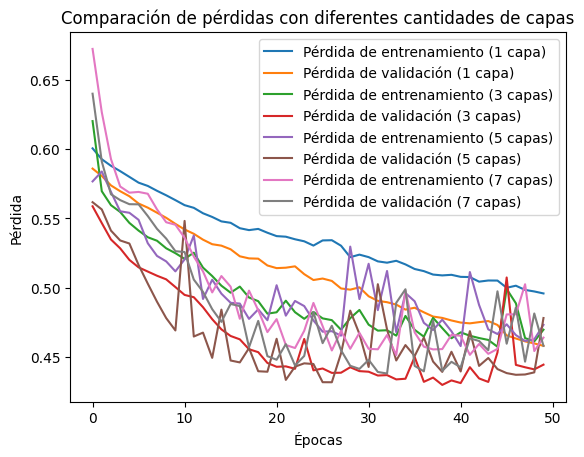

In [13]:
def crear_modelo_capas(num_capas):
    inputs = []
    feats_encoded = []

    for feat in cat_int_feats:
        input_feature = keras.Input(shape=(1,), name=feat, dtype="int64")
        encoded_feature = encode_categorical_feature(input_feature, feat, train_ds)
        inputs.append(input_feature)
        feats_encoded.append(encoded_feature)

    for feat in num_feats:
        input_feature = keras.Input(shape=(1,), name=feat)
        encoded_feature = encode_numerical_feature(input_feature, feat, train_ds)
        inputs.append(input_feature)
        feats_encoded.append(encoded_feature)

    all_feats = keras.layers.concatenate(feats_encoded)

    # Añadir la primera capa densa
    x = keras.layers.Dense(32, activation='relu')(all_feats)

    # Añadir las capas adicionales según el número especificado
    for _ in range(num_capas - 1):
        x = keras.layers.Dense(32, activation='relu')(x)

    output = keras.layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs=inputs, outputs=output)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Crear y entrenar modelos con diferentes números de capas
# Caso 1: Menos capas (1 capa)
model_1_capa = crear_modelo_capas(1)
history_1_capa = model_1_capa.fit(train_ds, validation_data=val_ds, epochs=50, verbose=0)

# Caso 2: Modelo base (3 capas)
model_3_capas = crear_modelo_capas(3)
history_3_capas = model_3_capas.fit(train_ds, validation_data=val_ds, epochs=50, verbose=0)

# Caso 3: Más capas (5 capas)
model_5_capas = crear_modelo_capas(5)
history_5_capas = model_5_capas.fit(train_ds, validation_data=val_ds, epochs=50, verbose=0)

# Caso 4: Muchas capas (7 capas)
model_7_capas = crear_modelo_capas(7)
history_7_capas = model_7_capas.fit(train_ds, validation_data=val_ds, epochs=50, verbose=0)

# Evaluar los modelos
print("Resultados con 1 capa:")
evaluar_modelo(model_1_capa, test_ds, y_true)

print("Resultados con 3 capas (modelo base):")
evaluar_modelo(model_3_capas, test_ds, y_true)

print("Resultados con 5 capas:")
evaluar_modelo(model_5_capas, test_ds, y_true)

print("Resultados con 7 capas:")
evaluar_modelo(model_7_capas, test_ds, y_true)

# Graficar las pérdidas para comparar los modelos
plt.plot(history_1_capa.history['loss'], label='Pérdida de entrenamiento (1 capa)')
plt.plot(history_1_capa.history['val_loss'], label='Pérdida de validación (1 capa)')
plt.plot(history_3_capas.history['loss'], label='Pérdida de entrenamiento (3 capas)')
plt.plot(history_3_capas.history['val_loss'], label='Pérdida de validación (3 capas)')
plt.plot(history_5_capas.history['loss'], label='Pérdida de entrenamiento (5 capas)')
plt.plot(history_5_capas.history['val_loss'], label='Pérdida de validación (5 capas)')
plt.plot(history_7_capas.history['loss'], label='Pérdida de entrenamiento (7 capas)')
plt.plot(history_7_capas.history['val_loss'], label='Pérdida de validación (7 capas)')
plt.title('Comparación de pérdidas con diferentes cantidades de capas')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()



Resultados con activación tanh:
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
               precision    recall  f1-score   support

No enfermedad       0.67      0.93      0.78        40
   Enfermedad       0.50      0.14      0.22        21

     accuracy                           0.66        61
    macro avg       0.59      0.53      0.50        61
 weighted avg       0.61      0.66      0.59        61

Matriz de confusión:
 [[37  3]
 [18  3]]
Resultados con activación elu:
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
               precision    recall  f1-score   support

No enfermedad       0.62      0.75      0.68        40
   Enfermedad       0.23      0.14      0.18        21

     accuracy                           0.54        61
    macro avg       0.43      0.45      0.43        61
 weighted avg       0.49      0.54      0.51        61

Matriz de confusión:
 [[30 10]
 [18  3]]
Resultados con activación selu:
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
               precision    recall  f1-s

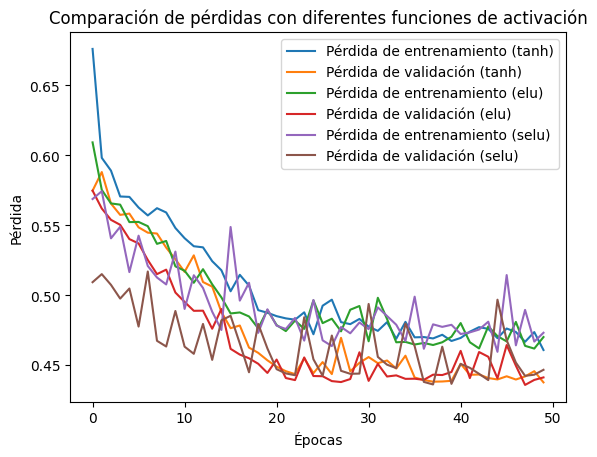

In [14]:
def crear_modelo_activacion(activacion):
    inputs = []
    feats_encoded = []

    for feat in cat_int_feats:
        input_feature = keras.Input(shape=(1,), name=feat, dtype="int64")
        encoded_feature = encode_categorical_feature(input_feature, feat, train_ds)
        inputs.append(input_feature)
        feats_encoded.append(encoded_feature)

    for feat in num_feats:
        input_feature = keras.Input(shape=(1,), name=feat)
        encoded_feature = encode_numerical_feature(input_feature, feat, train_ds)
        inputs.append(input_feature)
        feats_encoded.append(encoded_feature)

    all_feats = keras.layers.concatenate(feats_encoded)

    # Añadir capas densas con la función de activación especificada
    x = keras.layers.Dense(32, activation=activacion)(all_feats)
    x = keras.layers.Dense(32, activation=activacion)(x)
    x = keras.layers.Dense(32, activation=activacion)(x)

    output = keras.layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs=inputs, outputs=output)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Crear y entrenar modelos con diferentes funciones de activación
# Caso 1: Función de activación tanh
model_tanh = crear_modelo_activacion('tanh')
history_tanh = model_tanh.fit(train_ds, validation_data=val_ds, epochs=50, verbose=0)

# Caso 2: Función de activación elu
model_elu = crear_modelo_activacion('elu')
history_elu = model_elu.fit(train_ds, validation_data=val_ds, epochs=50, verbose=0)

# Caso 3: Función de activación selu
model_selu = crear_modelo_activacion('selu')
history_selu = model_selu.fit(train_ds, validation_data=val_ds, epochs=50, verbose=0)

# Evaluar los modelos
print("Resultados con activación tanh:")
evaluar_modelo(model_tanh, test_ds, y_true)

print("Resultados con activación elu:")
evaluar_modelo(model_elu, test_ds, y_true)

print("Resultados con activación selu:")
evaluar_modelo(model_selu, test_ds, y_true)

# Graficar las pérdidas para comparar los modelos
plt.plot(history_tanh.history['loss'], label='Pérdida de entrenamiento (tanh)')
plt.plot(history_tanh.history['val_loss'], label='Pérdida de validación (tanh)')
plt.plot(history_elu.history['loss'], label='Pérdida de entrenamiento (elu)')
plt.plot(history_elu.history['val_loss'], label='Pérdida de validación (elu)')
plt.plot(history_selu.history['loss'], label='Pérdida de entrenamiento (selu)')
plt.plot(history_selu.history['val_loss'], label='Pérdida de validación (selu)')
plt.title('Comparación de pérdidas con diferentes funciones de activación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


Resultados del modelo combinado:
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
               precision    recall  f1-score   support

No enfermedad       0.65      0.75      0.70        40
   Enfermedad       0.33      0.24      0.28        21

     accuracy                           0.57        61
    macro avg       0.49      0.49      0.49        61
 weighted avg       0.54      0.57      0.55        61

Matriz de confusión:
 [[30 10]
 [16  5]]
Resultados del modelo regularizado (Dropout y L2):
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
               precision    recall  f1-score   support

No enfermedad       0.66      1.00      0.79        40
   Enfermedad       0.00      0.00      0.00        21

     accuracy                           0.66        61
    macro avg       0.33      0.50      0.40        61
 weighted avg       0.43      0.66      0.52        61

Matriz de confusión:
 [[40  0]
 [21  0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


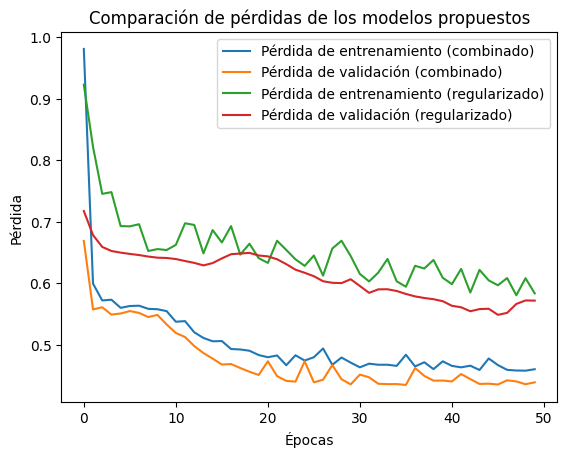

In [15]:
from tensorflow.keras import regularizers

# Modelo 1: Más capas y combinación de funciones de activación
def crear_modelo_combinado():
    inputs = []
    feats_encoded = []

    for feat in cat_int_feats:
        input_feature = keras.Input(shape=(1,), name=feat, dtype="int64")
        encoded_feature = encode_categorical_feature(input_feature, feat, train_ds)
        inputs.append(input_feature)
        feats_encoded.append(encoded_feature)

    for feat in num_feats:
        input_feature = keras.Input(shape=(1,), name=feat)
        encoded_feature = encode_numerical_feature(input_feature, feat, train_ds)
        inputs.append(input_feature)
        feats_encoded.append(encoded_feature)

    all_feats = keras.layers.concatenate(feats_encoded)

    # Capas con funciones de activación combinadas
    x = keras.layers.Dense(64, activation='relu')(all_feats)
    x = keras.layers.Dense(32, activation='tanh')(x)
    x = keras.layers.Dense(32, activation='selu')(x)
    x = keras.layers.Dense(16, activation='relu')(x)

    output = keras.layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs=inputs, outputs=output)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Modelo 2: Dropout y regularización L2
def crear_modelo_regularizado():
    inputs = []
    feats_encoded = []

    for feat in cat_int_feats:
        input_feature = keras.Input(shape=(1,), name=feat, dtype="int64")
        encoded_feature = encode_categorical_feature(input_feature, feat, train_ds)
        inputs.append(input_feature)
        feats_encoded.append(encoded_feature)

    for feat in num_feats:
        input_feature = keras.Input(shape=(1,), name=feat)
        encoded_feature = encode_numerical_feature(input_feature, feat, train_ds)
        inputs.append(input_feature)
        feats_encoded.append(encoded_feature)

    all_feats = keras.layers.concatenate(feats_encoded)

    # Capas con Dropout y regularización L2
    x = keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(all_feats)
    x = keras.layers.Dropout(0.3)(x)
    x = keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = keras.layers.Dropout(0.3)(x)
    x = keras.layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = keras.layers.Dropout(0.3)(x)

    output = keras.layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs=inputs, outputs=output)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Entrenar los modelos propuestos
# Modelo 1: Combinación de activaciones y más capas
model_combinado = crear_modelo_combinado()
history_combinado = model_combinado.fit(train_ds, validation_data=val_ds, epochs=50, verbose=0)

# Modelo 2: Dropout y regularización L2
model_regularizado = crear_modelo_regularizado()
history_regularizado = model_regularizado.fit(train_ds, validation_data=val_ds, epochs=50, verbose=0)

# Evaluar los modelos
print("Resultados del modelo combinado:")
evaluar_modelo(model_combinado, test_ds, y_true)

print("Resultados del modelo regularizado (Dropout y L2):")
evaluar_modelo(model_regularizado, test_ds, y_true)

# Graficar las pérdidas para comparar los modelos
plt.plot(history_combinado.history['loss'], label='Pérdida de entrenamiento (combinado)')
plt.plot(history_combinado.history['val_loss'], label='Pérdida de validación (combinado)')
plt.plot(history_regularizado.history['loss'], label='Pérdida de entrenamiento (regularizado)')
plt.plot(history_regularizado.history['val_loss'], label='Pérdida de validación (regularizado)')
plt.title('Comparación de pérdidas de los modelos propuestos')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()
